## MVP
After struggling to scrape Glassdoor.com, I realized it would actually be more useful to scrape Tapwage.com, a job description search engine owned by the same people as my previous employer, since I have insider knowledge about how it operates. In addition to being much simpler to scrape, the major benefit of Tapwage is the “Tags” that it assigns to each job description. These Tags are essentially elaborate Boolean expressions that apply if certain conditions are met; these conditions can be content-based (for example, apply the ‘PhD’ Tag if the description mentions ‘PhD’ or ‘PHD’ or ‘Ph.D.’ or ‘doctorate’ but not the phrase ‘not open to PhDs’, etc.) or company-based (for example, companies with publicly-traded stock are manually assigned the ‘Publicly Listed’ Tag). These Tags will be particularly useful in helping to guide topic modeling.

### Import Tools

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.util import ngrams
import re
import string
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielleronkos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Import Cleaned Dataframe
Using BeautifulSoup and Requests, I scraped 6,875 job description documents matching the search term PhD that were live on Tapwage on May 7, 2022 and May 8, 2022. I collected the following features:
- Job Title
- Company
- Location
- Unique ID (as assigned by Tapwage)
- Tapwage Tags
- Job Description text
- Headers (specifically tagged in website HTML)
- Bullet Points (specifically tagged in website HTML)

I used the PhD Tag to filter out some job descriptions that were erroneously collected (likely posts that expired so the site showed a random “related” job that ended up being scraped), leaving me with 6,815 relevant job descriptions. I also added additional count columns so I could look at some basic statistics -- how long is the average job description collected, how many bullet points does the average job description contain, how many sections is it (as counted by headers), how many Tags was the average job description assigned, etc.

In [2]:
## Sample of the data
df = pd.read_pickle('cleaned_tapwage_jds')
df.head()

,title,company,location,uid,tags,description,bullets,headers,phd_tag,tag_number,jd_length,header_number,bullets_number,bullets_percentage,bullets_length,bullets_merged
0,PhD Program & Lab Manager (Hybrid) job,Mass General Brigham,"Charlestown, MA",48022361,"[PhD, Masters Degree, Bachelor's Degree, Entry...",DescriptionJob Summary:The School of Health an...,"[Maintains appropriate office systems, word pr...","[Job Summary:, Job Duties:, Program Manager Ro...",False,9,11255,15,67,0.585695,6592,maintains appropriate office systems word pro...
1,PhD Program & Lab Manager (Hybrid) job,Massachusetts General Hospital,"Charlestown, MA",47983977,"[PhD, Masters Degree, Bachelor's Degree, Entry...",DescriptionJob Summary:The School of Health an...,"[Maintains appropriate office systems, word pr...","[Job Summary:, Job Duties:, Program Manager Ro...",False,9,11493,23,67,0.573567,6592,maintains appropriate office systems word pro...
2,Assistant Professor - Clinical PhD Program - L...,Bertelsmann,"Los Angeles, CA",48973936,"[PhD, Fortune500, Media, Junior, Full-Time]",Assistant Professor - Clinical PhD Program - L...,[Active scholarship and/or relevant teaching e...,"[Our Mission:, Our Vision:, Duties & Responsib...",False,5,14701,25,63,0.464798,6833,active scholarship and or relevant teaching ex...
3,Data Scientist / Statistician Intern (BS / MS ...,Lubrizol,"Hazelwood, DE",39232138,"[PhD, Bachelor's Degree, Data Science, Program...","Lubrizol, a Berkshire Hathaway company, is a m...",[Create predictive models by mining complex da...,[Data Scientist / Statistician Intern (BS/MS/P...,False,12,5075,7,17,0.276650,1404,create predictive models by mining complex dat...
4,PhD Scientist Internship job,Danaher Corporation,"Madison, WI",49810371,"[PhD, Fortune500, Publicly Listed, Conglomerat...",Aldevron is an industry pioneer with a core co...,[Express recombinant proteins in microbial or ...,"[Job Summary:, Responsibilities:, Qualificatio...",False,10,3494,5,9,0.275615,963,express recombinant proteins in microbial or e...


In [3]:
## Dataframe info and shape
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6815 entries, 0 to 6874
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               6815 non-null   object 
 1   company             6815 non-null   object 
 2   location            6815 non-null   object 
 3   uid                 6815 non-null   object 
 4   tags                6815 non-null   object 
 5   description         6815 non-null   object 
 6   bullets             6815 non-null   object 
 7   headers             6815 non-null   object 
 8   phd_tag             6815 non-null   bool   
 9   tag_number          6815 non-null   int64  
 10  jd_length           6815 non-null   int64  
 11  header_number       6815 non-null   int64  
 12  bullets_number      6815 non-null   int64  
 13  bullets_percentage  6815 non-null   float64
 14  bullets_length      6815 non-null   int64  
 15  bullets_merged      6815 non-null   object 
dtypes: boo

In [5]:
df.shape

(6815, 16)

### Tags
There are 298 unique Tags assigned to the 6,815 job in the corpus. The plot below shows counts for the top 15 most frequent Tags. Some initial impressions:
- Large companies seem more likely to hire PhDs (notably Fortune500 companies and Publicly Listed companies)
- Common skills mentioned in job descriptions hiring PhDs appear to be Programming, Python, Machine Learning, and C++
- A PhD may not actually be necessary for these positons, based on the inclusion of Bachelor's Degree and Masters Degree Tags in the top 15 most frequent

It will be interesting to see how unsupervised methods like topic modeling and clustering compare with these human-coded Tags.

In [6]:
tags_counts = pd.read_pickle('tags_counts_to_plot')

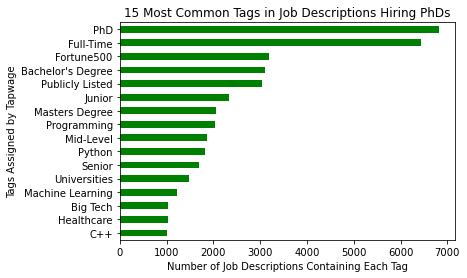

In [8]:
tags_counts.plot.barh(color='g')
plt.title("15 Most Common Tags in Job Descriptions Hiring PhDs")
plt.xlabel("Number of Job Descriptions Containing Each Tag")
plt.ylabel("Tags Assigned by Tapwage")
plt.gca().invert_yaxis()
plt.show()

### Job Description Length
Here we can see that most job descriptions are a little over 5,000 words long (mean = 5338 words, std = 2223 words).

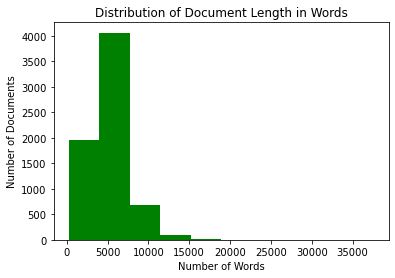

In [10]:
df.jd_length.plot.hist(color='g')
plt.title("Distribution of Document Length in Words")
plt.xlabel("Number of Words")
plt.ylabel("Number of Documents")
plt.show()

### Bullet Points
In my experience, the most meaningful parts of job descriptions -- particularly when it comes to comparing one job with another -- are in the sections composed with bullet points. These sections usually focus on the Qualifications and Skills candidates are expected to have in order to apply for a job, and the Responsibilities and Tasks they are expected to perform if they get hired. The plot below shows the portion of each job description document in the scraped corpus that is composed of bulleted lists. This plot suggests that 40 percent of most job description documents are text arranged in bulleted lists. When it comes to topic modeling, I plan to focus on these portions of the documents since they seem the most useful in making comparisons across domains.

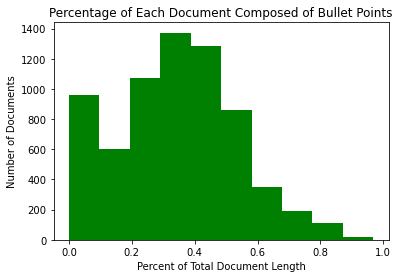

In [12]:
df.bullets_percentage.plot.hist(color='g')
plt.title("Percentage of Each Document Composed of Bullet Points")
plt.xlabel("Percent of Total Document Length")
plt.ylabel("Number of Documents")
plt.show()

### Creating a Document-Term Matrix
Setting the min_df threshold at .1 (meaning that included words must occur in at least 10 percent of all documents in the corpus) trims the list of terms from 19,920 to 231. Next steps will be to include some kind of lemmatizing and ngramming before beginning topic modeling.

In [13]:
## Subset of data containing only text that was included in bulleted lists
bullet_points_corpus = pd.read_pickle('bullet_points_corpus')

In [14]:
corpus = list(bullet_points_corpus.bullets_merged)

In [15]:
tokenized = [word_tokenize(word) for word in corpus]

In [16]:
cv = CountVectorizer(stop_words = 'english', min_df = .1)
X = cv.fit_transform(corpus)
dtm = pd.DataFrame(X.toarray(), columns = cv.get_feature_names())

/Users/danielleronkos/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
## Drops from 19920 words vectorized to 231 if you make min df threshold .1
dtm.head()

,10,ability,able,academic,active,activities,advanced,algorithms,analysis,analytical,...,using,various,verbal,vision,work,working,writing,written,year,years
0,0,4,1,1,0,0,0,0,1,0,...,0,0,0,0,2,4,0,0,0,1
1,0,4,1,1,0,0,0,0,1,0,...,0,0,0,0,2,4,0,0,0,1
2,0,10,0,3,5,1,0,0,0,0,...,0,0,0,0,4,1,0,0,0,1
3,0,2,0,0,0,0,1,2,0,0,...,4,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,1,1,0,0,0,0


In [18]:
dtm.shape

(6119, 259)

In [19]:
dtm.describe()

,10,ability,able,academic,active,activities,advanced,algorithms,analysis,analytical,...,using,various,verbal,vision,work,working,writing,written,year,years
count,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,...,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000
mean,0.187612,1.421311,0.241379,0.234842,0.146756,0.334532,0.404151,0.202974,0.823337,0.250041,...,0.377840,0.165223,0.209185,0.202321,1.815656,0.654682,0.173721,0.375061,0.175519,2.212126
std,0.525365,2.063231,0.644143,0.724747,0.509186,0.823825,0.843367,0.669455,1.409700,0.674021,...,0.804372,0.472513,0.441076,0.614142,2.051003,1.028949,0.521887,0.577195,0.615467,2.433041
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000,1.000000,0.000000,3.000000
max,5.000000,25.000000,8.000000,10.000000,10.000000,10.000000,8.000000,9.000000,16.000000,11.000000,...,9.000000,6.000000,3.000000,9.000000,15.000000,10.000000,10.000000,5.000000,9.000000,21.000000
